In [17]:
%pylab inline
from richLowCost_copy import * 
Vgrid = np.load("richLow.npy")
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})

Populating the interactive namespace from numpy and matplotlib


In [2]:
# total number of agents
num = 10000
'''
    x = [w,n,m,s,e,o,z]
    x = [5,0,0,0,0,0,0]
'''

from jax import random
from quantecon import MarkovChain
# number of economies and each economy has 100 agents
numEcon = 100
numAgents = 100
mc = MarkovChain(Ps)
econStates = mc.simulate(ts_length=T_max-T_min,init=0,num_reps=numEcon)
econStates = jnp.array(econStates,dtype = int)

def simulation(key):
    initE = random.choice(a = nE, p=E_distribution, key = key)
    initS = random.choice(a = nS, p=S_distribution, key = key)
    x = [5, 0, 0, initS, initE, 0, 0]
    path = []
    move = []
    # first 100 agents are in the 1st economy and second 100 agents are in the 2nd economy 
    econ = econStates[key.sum()//numAgents,:]
    for t in range(T_min, T_max):
        _, key = random.split(key)
        if t == T_max-1:
            _,a = V(t,Vgrid[:,:,:,:,:,:,:,t],x)
        else:
            _,a = V(t,Vgrid[:,:,:,:,:,:,:,t+1],x)
        xp = transition(t,a.reshape((1,-1)),x)            
        xp = jnp.multiply(xp,(xp[:,3] == econ[t]).repeat(nS).reshape((xp.shape[0], nS)))
        p = xp[:,-1]
        x_next = xp[:,:-1]
        path.append(x)
        move.append(a)
        x = x_next[random.choice(a = nS*nE, p=p, key = key)]
    path.append(x)
    return jnp.array(path), jnp.array(move)

In [3]:
%%time
# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)

CPU times: user 10h 52min 22s, sys: 1h 6min 38s, total: 11h 59min
Wall time: 35min 29s


In [4]:
# x = [w,n,m,s,e,o,z]
# x = [0,1,2,3,4,5,6]
ws = Paths[:,:,0].T
ns = Paths[:,:,1].T
ms = Paths[:,:,2].T
ss = Paths[:,:,3].T
es = Paths[:,:,4].T
os = Paths[:,:,5].T
zs = Paths[:,:,6].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T
actions = Moves[:,:,4].T

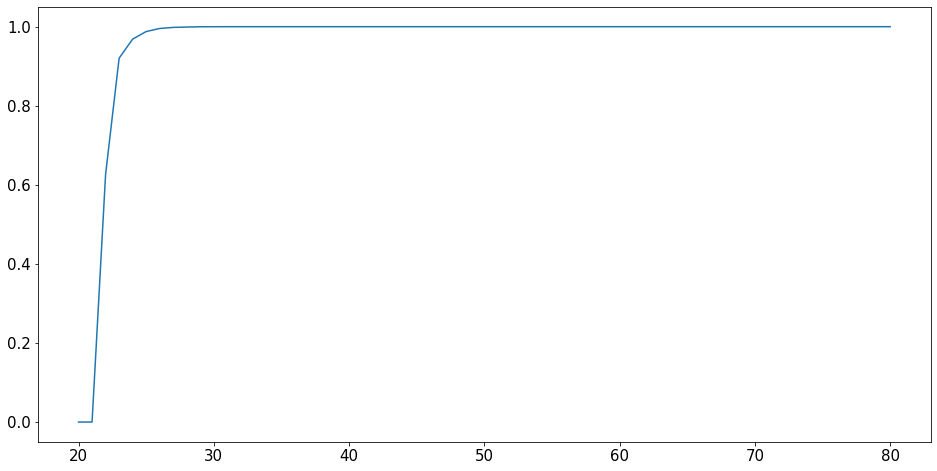

In [5]:
plt.plot(range(20, T_max + 21),jnp.mean(zs,axis = 1), label = "experience")

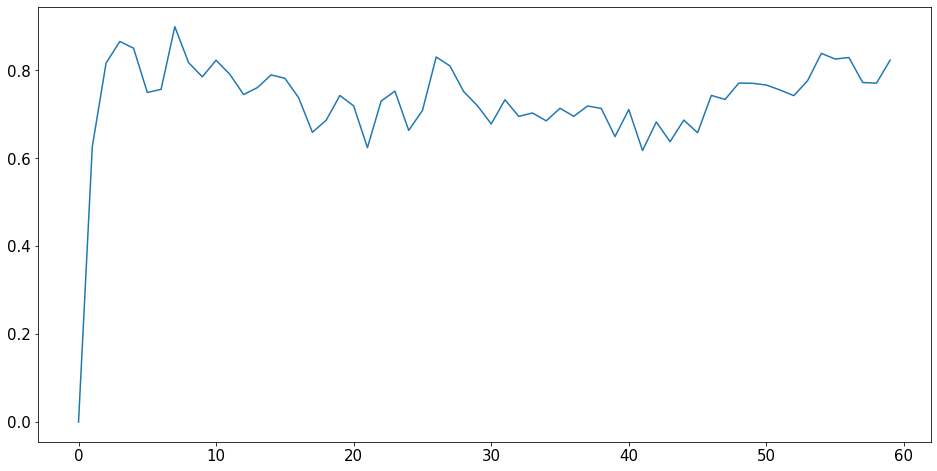

In [6]:
plt.plot((ks>0).mean(axis = 1))

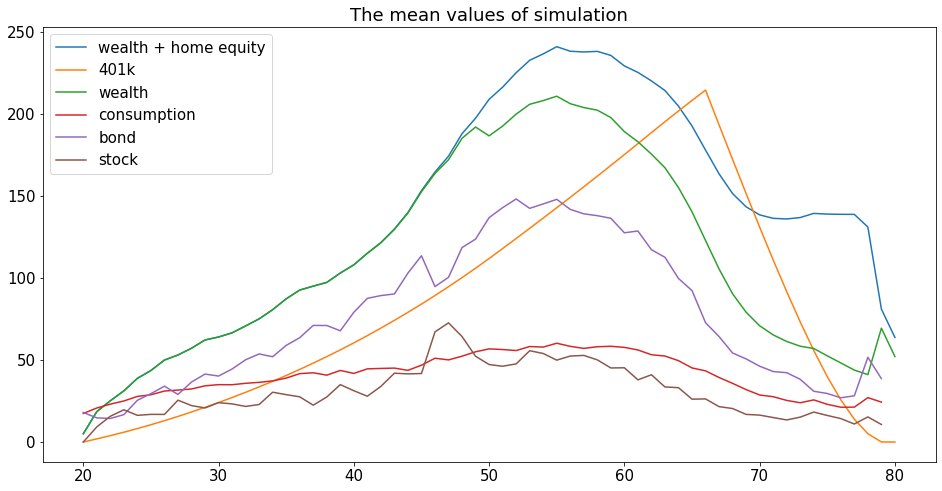

In [7]:
plt.title("The mean values of simulation")
plt.plot(range(20, T_max + 21),jnp.mean(ws + H*pt*os - ms,axis = 1), label = "wealth + home equity")
plt.plot(range(20, T_max + 21),jnp.mean(ns,axis = 1), label = "401k")
plt.plot(range(20, T_max + 21),jnp.mean(ws,axis = 1), label = "wealth")
plt.plot(range(20, T_max + 20),jnp.mean(cs,axis = 1), label = "consumption")
plt.plot(range(20, T_max + 20),jnp.mean(bs,axis = 1), label = "bond")
plt.plot(range(20, T_max + 20),jnp.mean(ks,axis = 1), label = "stock")
plt.legend()

In [8]:
jnp.mean(ws,axis = 1)[30]

DeviceArray(186.60164, dtype=float32)

In [9]:
jnp.mean(os,axis = 1)[30]

DeviceArray(0.2146, dtype=float32)

In [10]:
jnp.mean(zs,axis = 1)[10]

DeviceArray(0.9999, dtype=float32)

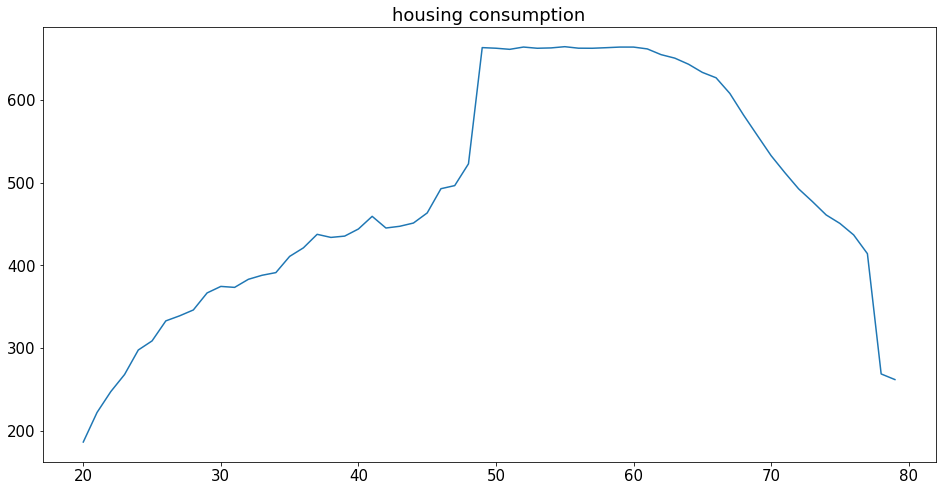

In [11]:
plt.title("housing consumption")
plt.plot(range(20, T_max + 20),(hs).mean(axis = 1), label = "housing")

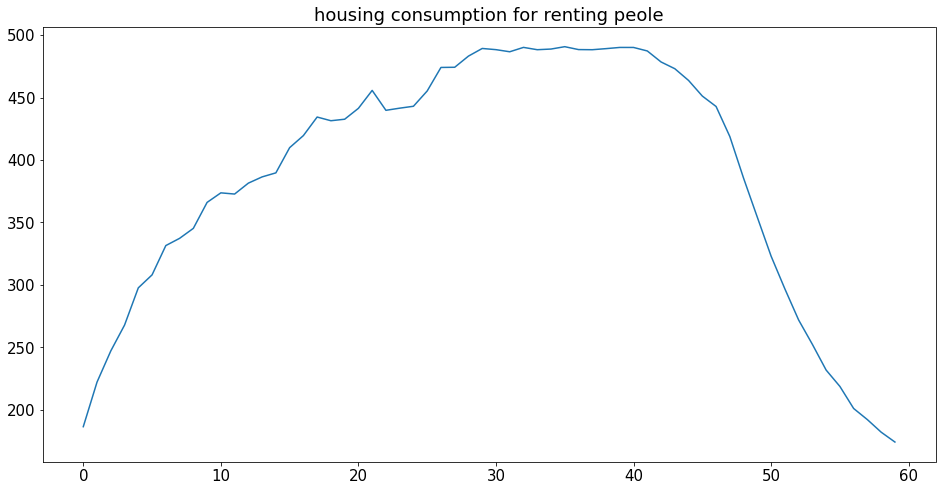

In [12]:
plt.title("housing consumption for renting peole")
plt.plot(hs[:, jnp.where(os.sum(axis = 0)  == 0)[0]].mean(axis = 1), label = "housing")

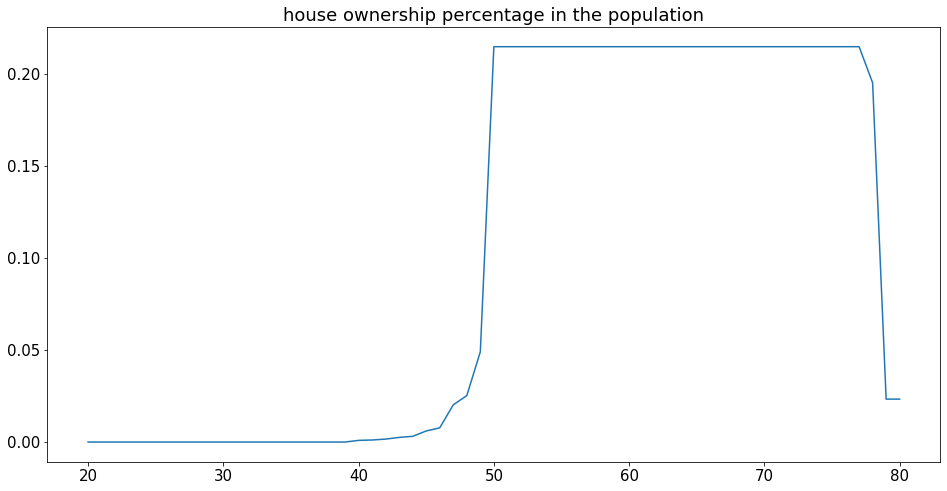

In [13]:
plt.title("house ownership percentage in the population")
plt.plot(range(20, T_max + 21),(os).mean(axis = 1), label = "owning")

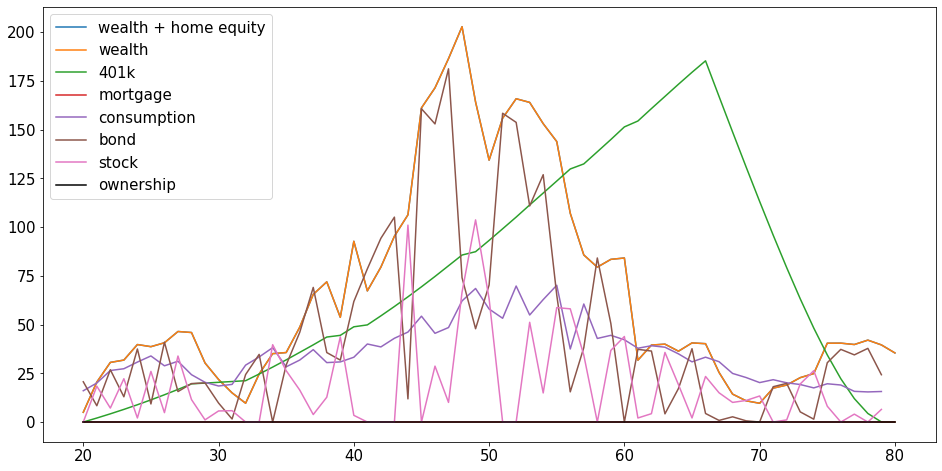

In [14]:
# agent number, x = [w,n,m,s,e,o]
agentNum = 35
plt.plot(range(20, T_max + 21),(ws + os*(H*pt - ms))[:,agentNum], label = "wealth + home equity")
plt.plot(range(20, T_max + 21),ws[:,agentNum], label = "wealth")
plt.plot(range(20, T_max + 21),ns[:,agentNum], label = "401k")
plt.plot(range(20, T_max + 21),ms[:,agentNum], label = "mortgage")
plt.plot(range(20, T_max + 20),cs[:,agentNum], label = "consumption")
plt.plot(range(20, T_max + 20),bs[:,agentNum], label = "bond")
plt.plot(range(20, T_max + 20),ks[:,agentNum], label = "stock")
plt.plot(range(20, T_max + 21),os[:,agentNum]*100, label = "ownership", color = "k")
plt.legend()

In [ ]:
age = 50
stockRatio = ks[age,:] / (ks[age,:] + bs[age,:])
state = ss[age,:]
own = os[age,:]
list_of_tuples = list(zip(stockRatio, state, own)) 
df = pd.DataFrame(list_of_tuples,columns = ['stockRatio', "econState", "own"]) 
owner = df[df["own"] == 1]
renter = df[df["own"] == 0]
plt.plot(owner.groupby("econState")["stockRatio"].mean().values.flatten(), label = "Owner")
plt.plot(renter.groupby("econState")["stockRatio"].mean().values.flatten(), label = "Renter")
plt.legend()

In [ ]:
plt.figure(figsize = [12,6])
plt.title("Stock investment ratio")
plt.plot((es[:T_max,:]*(ks/(ks+bs))).mean(axis = 1), label = "employed")
plt.plot(((1-es[:T_max,:])*(ks/(ks+bs))).mean(axis = 1), label = "unemployed")
plt.legend()

In [ ]:
# # agent selling time collection
# agentTime = []
# for t in range(30):
#     if ((os[t,:] == 0) & (os[t+1,:] == 1)).sum()>0:
#         for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 1))[0]:
#             agentTime.append([t, agentNum])
# agentTime = jnp.array(agentTime)

In [ ]:
# # agent selling time collection
# agentHold = []
# for t in range(30):
#     if ((os[t,:] == 0) & (os[t+1,:] == 0)).sum()>0:
#         for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 0))[0]:
#             agentHold.append([t, agentNum])
# agentHold = jnp.array(agentHold)

In [ ]:
# plt.title("weath level for buyer and renter")
# www = (os*(ws+H*pt - ms)).sum(axis = 1)/(os).sum(axis = 1)
# for age in range(30):
#     buyer = agentTime[agentTime[:,0] == age]
#     renter = agentHold[agentHold[:,0] == age]
#     plt.scatter(age, ws[buyer[:,0], buyer[:,1]].mean(),color =  "b")
#     plt.scatter(age, www[age], color = "green")
#     plt.scatter(age, ws[renter[:,0], renter[:,1]].mean(),color =  "r")

In [ ]:
# plt.title("employement status for buyer and renter")
# for age in range(31):
#     buyer = agentTime[agentTime[:,0] == age]
#     renter = agentHold[agentHold[:,0] == age]
#     plt.scatter(age, es[buyer[:,0], buyer[:,1]].mean(),color =  "b")
#     plt.scatter(age, es[renter[:,0], renter[:,1]].mean(),color =  "r")

In [ ]:
# # At every age
# plt.plot((os[:T_max,:]*ks/(ks+bs)).sum(axis = 1)/os[:T_max,:].sum(axis = 1), label = "owner")
# plt.plot(((1-os[:T_max,:])*ks/(ks+bs)).sum(axis = 1)/(1-os)[:T_max,:].sum(axis = 1), label = "renter")
# plt.legend()

In [ ]:
# # At every age
# plt.plot((os[:T_max,:]*ks).sum(axis = 1)/os[:T_max,:].sum(axis = 1), label = "owner")
# plt.plot(((1-os[:T_max,:])*ks).sum(axis = 1)/(1-os)[:T_max,:].sum(axis = 1), label = "renter")
# plt.legend()

In [18]:
# x = [w,n,m,s,e,o,z]
Vgrid.shape

(20, 10, 10, 8, 2, 2, 2, 60)

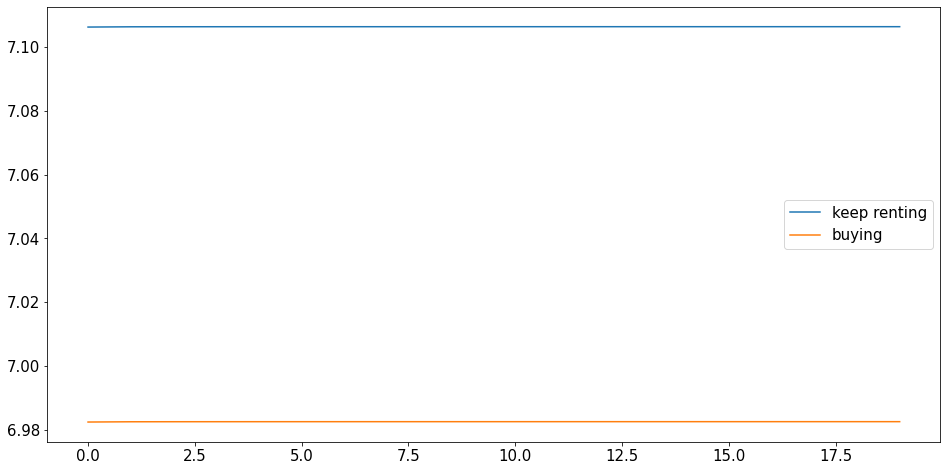

In [22]:
plt.plot(Vgrid[:,0,0,0,0,0,0,0], label = "keep renting")
plt.plot(Vgrid[:,0,0,0,0,0,0,1], label = "buying")
plt.legend()

In [25]:
xgrid.shape

(20, 10, 10, 8, 2, 2, 2, 7)